In [7]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.special import jn,jnp_zeros,jvp,yn,yvp,hankel2,h2vp

In [18]:
'''
Author: LRayX liruixiang@zju.edu.cn
Date: 2023-11-22 11:18:48
LastEditors: LRayX liruixiang@zju.edu.cn
LastEditTime: 2023-11-22 12:50:48
FilePath: \AcousticalWaveModels\acoustic_wave_models.ipynb
Description: This file is about acoustic wave models
Copyright (c) 2023 by LRayX liruixiang@zju.edu.cn, All Rights Reserved. 
'''
class Signal:
    def __init__(self, _T, _fs, _signal = None):
        self.T = _T
        self.fs = _fs
        self.length = int(self.T*self.fs)
        self.time_series = 1/self.fs*np.arange(self.length)
        self.signal = _signal

    def rectangle_pulse(self, A = 1.0,):
        self.signal = A*np.ones(self.length)
    
    def gaussian_pulse(self, A = 1.0, sigma = 0.0001,):
        mean = self.T/2
        self.signal = A*np.exp(-(self.time_series - mean)**2 / (2 * sigma**2))

    def squared_sine_pulse(self, A = 1.0):
        self.signal = A*np.sin(np.pi/self.T*self.time_series)**2

    def add_zero(self, *args):
        num_args = len(args)
        if num_args == 0:
            _N = 2**math.ceil(math.log(self.length,2))
        else:
            _N = args[0]
        zero_length = _N - self.length
        self.length = _N
        self.signal = np.append(self.signal, np.zeros(zero_length))
        self.time_series = 1/self.fs*np.arange(self.length)



class EWM:
    def __init__(self, _delta_frequency,m):
    # delta_frequency = fs/N = 1/T
        self.delta_frequency = _delta_frequency
        self.eta = math.log(10)*m*self.delta_frequency
        
    def falling_exp_window(self, vector, time_series):
        exponential_time_series = np.exp(-self.eta*time_series)
        return np.multiply(vector,exponential_time_series)
    
    def rising_exp_window(self, vector, time_series):
        exponential_time_series = np.exp(self.eta*time_series)
        return np.multiply(vector,exponential_time_series)




class SimplifiedModel:
    def __init__(self, _T, _fs,  _radius, _c, _rho, _strength, _num_modes,  _distance_off_center = 0):
        self.T = _T
        self.fs = _fs
        self.radius = _radius
        self.c = _c
        self.rho = _rho
        self.strength = _strength
        self.num_modes =  _num_modes
        self.distance_off_center = _distance_off_center
        
    def transfer(self, r, theta, z, w):
        if self.distance_off_center == 0:
            # in this case , result independent of theta
            #z denote zeros of the functions J_n'(x)
            n = 0
            k = np.array(jnp_zeros(n,self.num_modes))/self.radius
            k_0 = w/self.c
            sqrt_vec = np.sqrt(k_0*k_0-k*k)
            truncated_series =  np.exp(-1j*z*sqrt_vec)/sqrt_vec*jn(n, k*r)/(jn(n, k*self.radius)*jn(n, k*self.radius))
            transfer_function = np.sum(truncated_series)
            return transfer_function
             
        else:
            print(f"The code is not available for off-center ponint souce")
            
    def displacement_response(self, r, theta, z, eta = 0):
        N = len(self.strength)//2 + 1
        w = 2*np.pi*self.fs/len(self.strength)*np.arange(len(self.strength)) - 1j*eta
        displacement = np.zeros(N, dtype=complex)
        for i in range(N):
            displacement[i] = 1j/(2*np.pi*self.radius*self.radius)*self.transfer(r, theta, z, w[i])*self.strength[i]
        conj_displacement = np.conjugate(displacement[1:-1])[::-1]
        displacement = np.append(displacement, conj_displacement)
        return displacement
    def pressure_response(self, r, theta, z, eta = 0):
        N = len(self.strength)//2 + 1
        w = 2*np.pi*self.fs/len(self.strength)*np.arange(len(self.strength)) - 1j*eta
        pressure = np.zeros(N, dtype=complex)
        for i in range(N):
            pressure[i] = self.rho/(self.c*self.radius*self.radius)*w[i]*self.transfer(r, theta, z, w[i])*self.strength[i]
        conj_pressure = np.conjugate(pressure[1:-1])[::-1]
        pressure = np.append(pressure, conj_pressure)
        return pressure
'''
description: 
param {*} T: time of pulse we want
param {*} fs: sample rate of the pulse
param {*} id: id == 0 means rectangle pulse; id == 1 means gaussian pulse; id == 2 means 
param {array} arg: the array means the parameters to initialize pulse. 
                If it is empty, means default parameters; 
                If it contains some parameters, just use these parameters in the order.
return {*}
'''
def pulse_init(T, fs, id, *arg):
    pulse = Signal(T, fs)
    if id == 0:
        if len(arg) > 0:
            pulse.rectangle_pulse(arg[0])
        else:
            pulse.rectangle_pulse()
    elif id == 1:
        if len(arg) == 0:
            pulse.gaussian_pulse()
        elif len(arg) == 1:
            pulse.gaussian_pulse(arg[0])
        else:
            pulse.gaussian_pulse(arg[0],arg[1])
    elif id == 2:
        if len(arg) == 0:
            pulse.squared_sine_pulse()
        else:
            pulse.squared_sine_pulse(arg[0])
    return pulse
'''
description: Solver of Simplified Model
param {*} T: Time range of original singal 
param {*} fs: Sample rate
param {*} m: A para to calculate shifting para eta
param {*} R: The radius of pipe
param {*} c: The sound speed in fliud(water)
param {*} rho: The density of fliud
param {*} _num_terms: The number of terms of truncated Bessel series
param {*} r: The radius distance of the point we choose 
param {*} z: The axis distance of the point we choose
param {*} time_domain: The time range we want to calculate, recommended integer times of T 
param {*} *arg: if id=0, rectangle
return {*}: displacement in TD; pressure in TD; displacement in FD; pressure in FD; discreted time series of [0,time_domain]
'''
def Solver_SimplifiedModel(T, fs, pulse, m, R, c ,rho, _num_terms, r, z, time_range):
    '''init EWM'''
    _delta_frequency =  1/T
    ewm = EWM(_delta_frequency,m)
    '''EWM and then add zero'''
    pulse.signal = ewm.falling_exp_window(pulse.signal, pulse.time_series)
    '''N claims the lenrth of vector if we want to calculate to time time_range'''
    N = 2*int(time_range*fs/2)
    # time_series = 1/fs*np.arange(N)
    pulse.add_zero(N)
    '''fft'''
    _strength = np.fft.fft(pulse.signal)
    '''calculate response'''
    simplemodel = SimplifiedModel(time_range,fs, R, c, rho, _strength, _num_terms)
    theta = 0
    displacement_response = simplemodel.displacement_response(r, theta, z, ewm.eta)
    pressure_response = simplemodel.pressure_response(r, theta, z,ewm.eta)
    '''IFFT'''
    displacement = np.fft.ifft(displacement_response)
    pressure = np.fft.ifft(pressure_response)
    '''REW'''
    displacement = ewm.rising_exp_window(displacement, pulse.time_series)
    pressure = ewm.rising_exp_window(pressure, pulse.time_series)
    '''output time_series to make it convenient to draw curve'''
    time_series = pulse.time_series
    
    return displacement, pressure, displacement_response, pressure_response, time_series

The theoretical time it takes for sound to travel z is 0.011999999999999999(s) and it is already marked on the diagram with a red dotted line


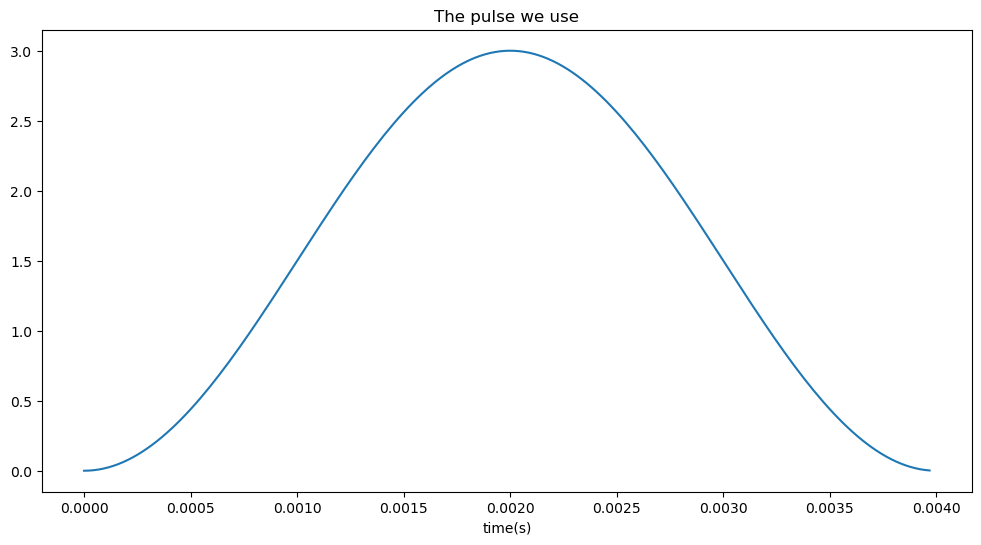

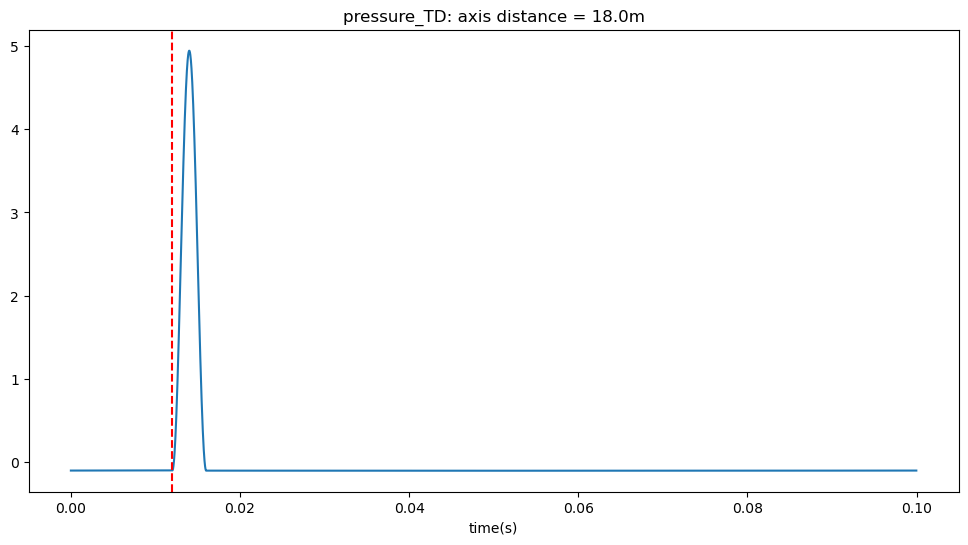

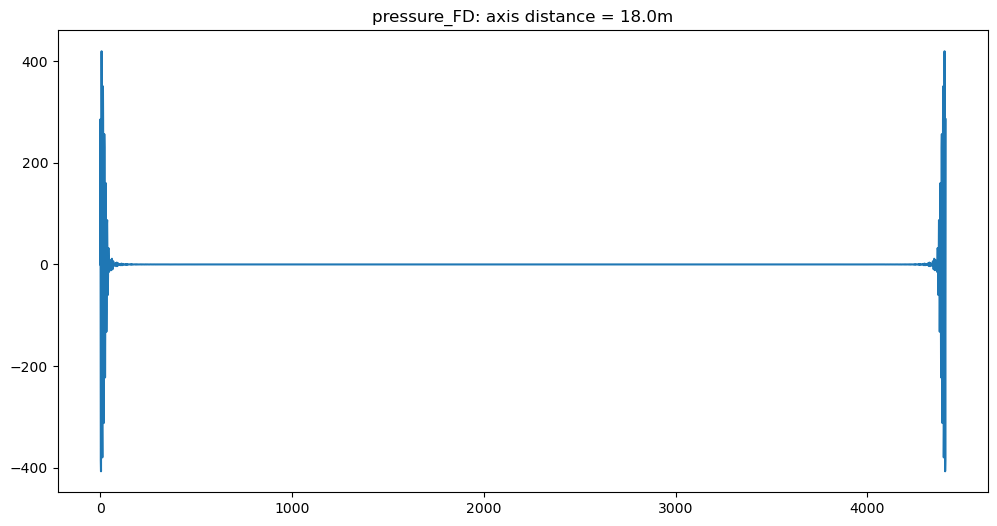

In [19]:
'''table of parameters'''
T = 0.004           # pulse duration (s)
fs = 44100          # sample rate of pulse (Hz)
m = 0               # parameter for EWM, m = 0 means no need to use exponential window
R = 1               # radius of pipe (m)
c = 1.5             # speed of sound in fluid (km/s)
num_modes = 1       # number of modes
rho = 1.0           # density of fluid
z = 18              # axis distance from the source (m)
r = 0.5             # radius distance from the source
time_range = 0.1    # the time domain we need, recommend integer times of T (s)
id = 2              # id = 0 rectangle, id = 1 gaussian, id = 2 squared sinusoidal wavelet
'''caculate and draw'''
#######################################################
'''transform axis distance to km'''
z = z/1000
'''init pulse'''
A = 3.0             # amplitude of different pulse
sigma = 0.0005      # standard deviation of gaussian pulse
pulse = pulse_init(T, fs, id, A)
'''plot the pulse we use'''
plt.figure(1)
plt.plot(pulse.time_series, pulse.signal)
plt.title('The pulse we use')
plt.xlabel('time(s)')
'''call the Solver function'''
displacement, pressure, displacement_response, pressure_response, t = Solver_SimplifiedModel(T, fs, pulse, m, R, c ,rho, num_modes, r, z, time_range)
print(f'The theoretical time it takes for sound to travel z is {z/c}(s) and it is already marked on the diagram with a red dotted line')
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.figure(2)
plt.plot(t,pressure)
plt.axvline(x=z/c, color='red', linestyle='--')
plt.title(f'pressure_TD: axis distance = {1000*z}m')
plt.xlabel('time(s)')
plt.figure(3)
plt.plot(pressure_response)
plt.title(f'pressure_FD: axis distance = {1000*z}m')
plt.show()

In [21]:
'''Component of LayeredSystem'''
class CylindricalLayer:
    def __init__(self, _external_radius, _internal_radius, _p_wave_velocity, _s_wave_velocity, _lame_constant, _shear_modulus):
        self.external_radius = _external_radius
        self.internal_radius = _internal_radius
        self.p_wave_velocity = _p_wave_velocity
        self.s_wave_velocity = _s_wave_velocity
        self.lame_constant = _lame_constant
        self.shear_modulus = _shear_modulus

class SinglerLayer(CylindricalLayer):
    def __init__(self, _external_radius, _internal_radius, _p_wave_velocity, _s_wave_velocity, _lame_constant, _shear_modulus):
        super().__init__(_external_radius, _internal_radius, _p_wave_velocity, _s_wave_velocity, _lame_constant, _shear_modulus)
    def stiffnessmatrix(self, w, kz, order):
        '''Left Matrix'''
        F00 = self.external_radius*stresses_matrix(w, self.external_radius, kz, self.lame_constant, self.shear_modulus, self.p_wave_velocity, self.s_wave_velocity, jn, jvp, order)
        F01 = self.external_radius*stresses_matrix(w, self.external_radius, kz, self.lame_constant, self.shear_modulus, self.p_wave_velocity, self.s_wave_velocity, yn, yvp, order)
        F10 = -self.internal_radius*stresses_matrix(w, self.internal_radius, kz, self.lame_constant, self.shear_modulus, self.p_wave_velocity, self.s_wave_velocity, jn, jvp, order)
        F11 = -self.internal_radius*stresses_matrix(w, self.internal_radius, kz, self.lame_constant, self.shear_modulus, self.p_wave_velocity, self.s_wave_velocity, yn, yvp, order)
        L = np.block([[F00, F01], [F10, F11]])

        '''Right Matrix'''
        B00 = displacement_matrix(w, self.external_radius, kz, self.p_wave_velocity, self.s_wave_velocity, jn, jvp, order)
        B01 = displacement_matrix(w, self.external_radius, kz, self.p_wave_velocity, self.s_wave_velocity, yn, yvp, order)
        B10 = displacement_matrix(w, self.internal_radius, kz, self.p_wave_velocity, self.s_wave_velocity, jn, jvp, order)
        B11 = displacement_matrix(w, self.internal_radius, kz, self.p_wave_velocity, self.s_wave_velocity, yn, yvp, order)
        R = np.block([[B00, B01], [B10, B11]])
        R = np.linalg.inv(R)

        '''Stiffness Matrix'''
        StiffnessMatrix = np.dot(L, R)
        return StiffnessMatrix

# def stresses_matrix(w, r, kz, lame_constant, shear_modulus, p_wave_velocity, s_wave_velocity, bessel_function, bessel_prime, order):
# displacement_matrix(w, r, kz, p_wave_velocity, s_wave_velocity, bessel_function, bessel_prime, order):
class InfiniteMedium(CylindricalLayer):
    def __init__(self, _internal_radius, _p_wave_velocity, _s_wave_velocity, _lame_constant, _shear_modulus):
        super().__init__(None, _internal_radius, _p_wave_velocity, _s_wave_velocity, _lame_constant, _shear_modulus)
    def stiffnessmatrix(self, w, kz, order):
        F = stresses_matrix(w, self.internal_radius, kz,self.lame_constant, self.shear_modulus, self.p_wave_velocity, self.s_wave_velocity, hankel2, h2vp, order)
        H = displacement_matrix(w, self.internal_radius, kz, self.p_wave_velocity, self.s_wave_velocity, hankel2, h2vp, order)
        StiffnessMatrix = -self.internal_radius*np.dot(F, H)

        return StiffnessMatrix

class CoreFluid(CylindricalLayer):
    def __init__(self, _external_radius,  _p_wave_velocity, _s_wave_velocity, _lame_constant, _shear_modulus):
        super().__init__(_external_radius, 0, _p_wave_velocity, _s_wave_velocity, _lame_constant, _shear_modulus)
    def stiffnessmatrix(self, w, kz, order):
        F = stresses_matrix(w, self.external_radius, kz,self.lame_constant, self.shear_modulus, self.p_wave_velocity, self.s_wave_velocity, jn, jvp, order)
        H = displacement_matrix(w, self.external_radius, kz, self.p_wave_velocity, self.s_wave_velocity, jn, jvp, order)
        StiffnessMatrix = self.external_radius*np.dot(F, H)

        return StiffnessMatrix

'''
Layered System
If there exists serveral layers, the input prarmeters should be a set of layer. 
BUt there must be and can only be one only be one core fluid/infintemedium.
'''

class LayeredSystem:
    def __init__(self, _layer, _corefluid ,_infinitemedium ):
        self.layer = _layer
        self.corefluid = _corefluid
        self.infinitemedium = _infinitemedium

class SimpleLayeredSystem(LayeredSystem):
    def __init__(self, _layer, _corefluid, _infinitemedium, _wave_speed):
        super().__init__(_layer, _corefluid, _infinitemedium)
        self.a = self.corefluid.external_radius
        self.b = self.layer.external_radius
        self.wavespeed = _wave_speed
    def radial_displacement(self, w, z, kz, strength): 
        k = np.sqrt((w/self.wavespeed)**2-kz**2) 
        RadialDisplacement = -strength*k/(4*w)*hankel2(1, k*self.b,1)*np.exp(-kz*z)

        return RadialDisplacement

    def pressure_response(self, w, z, kz, strength ,order):
        Kfi = self.corefluid.stifffness(w, kz ,order)[0,0]
        Kfe = self.infinitemedium.stiffness(w, kz, order)[0,0]
        
        K = self.layer.stiffness(w, kz, order)
        K11 = K[0,0]
        K12 = K[0,1:5]
        K21 = K[1:5,0]
        K22 = K[1:5,1:5]

        K22 = np.linalg.inv(K22)
        Kcons = K11 - K12 @ K22 @ K21

        pressure = (1 - Kfi*1/Kcons)*(Kfe + Kfi) * self.radial_displacement(w, z, kz, strength)

        return pressure



'''Gernerator of Stiffness Matrix'''
def displacement_matrix(w, r, kz, p_wave_velocity, s_wave_velocity, bessel_function, bessel_prime, order):
    DisplacementMatrix = np.zeros((3,3))

    kp = w/p_wave_velocity
    ks = w/s_wave_velocity

    ka = np.sqrt(kp**2-kz**2)
    kb = np.sqrt(ks**2-kz**2)

    element_a = bessel_function(order,ka*r)
    element_b = bessel_function(order,kb*r)

    element_prime_a = bessel_prime(order, ka*r)
    element_prime_b = bessel_prime(order, kb*r)

    DisplacementMatrix[0,0] = element_prime_a
    DisplacementMatrix[0,1] = order*element_b/(kb*r)
    DisplacementMatrix[0,2] = kz/kb*element_prime_b

    DisplacementMatrix[1,0] = order*element_a/(ka*r)
    DisplacementMatrix[1,1] = element_prime_b
    DisplacementMatrix[1,2] = order*kz/kb*element_b/(kb*r)

    DisplacementMatrix[2,0] = -kz/ka*element_a
    DisplacementMatrix[2,1] = 0
    DisplacementMatrix[2,2] = element_b

    return DisplacementMatrix

'''Generator of Stresses Matrix'''
def stresses_matrix(w, r, kz, lame_constant, shear_modulus, p_wave_velocity, s_wave_velocity, bessel_function, bessel_prime, order):
    StressesmentMatrix = np.zeros((3,3))

    kp = w/p_wave_velocity
    ks = w/s_wave_velocity

    ka = np.sqrt(kp**2-kz**2)
    kb = np.sqrt(ks**2-kz**2)

    element_a = bessel_function(order,ka*r)
    element_b = bessel_function(order,kb*r)

    element_prime_a = bessel_prime(order, ka*r)
    element_prime_b = bessel_prime(order, kb*r)

    StressesmentMatrix[0,0] = -ka*(lame_constant*(1+(kz/ka)**2)*element_a + 2.0*shear_modulus*(element_prime_a/(ka*r)+(1-(order/(ka*r))**2)*element_a))
    StressesmentMatrix[0,1] = 2.0*order*shear_modulus/r*(element_prime_b - element_b/(kb*r))
    StressesmentMatrix[0,2] = -2.0*kz*shear_modulus*(element_prime_b/(kb*r) + (1-(order/(kb*r))**2)*element_b)

    StressesmentMatrix[1,0] = 2.0*order*shear_modulus/r*(element_prime_a - element_a/(ka*r))
    StressesmentMatrix[1,1] = -kb*shear_modulus*(2*element_prime_b/(kb*r)+(1 - 2.0*(order/(kb*r))**2)*element_b)
    StressesmentMatrix[1,2] = kz*2.0*order*shear_modulus/(kb*r)*(element_prime_b - element_b/(kb*r))

    StressesmentMatrix[2,0] = -2.0*kz*shear_modulus*element_prime_b
    StressesmentMatrix[2,1] = -kz*order*shear_modulus*element_prime_b/(kb*r)
    StressesmentMatrix[2,2] = kb*shear_modulus*(1 - (kz/kb)**2)*element_prime_b

    return StressesmentMatrix




In [20]:
# # table of parameters
# T = 0.005    # pulse duration (s)
# fs = 44100   # sample rate of pulse (Hz)
# h = 1       # height of pulse
# m = 0      # parameter for EWM
# R = 1        # radius of pipe (m)
# c = 1.5      # speed of sound in fluid (km/s)
# _num_terms = 8  # terms of Bessel function at least 8
# rho = 1.0    # density of fluid
# z = 0.15     # axis distance from the source (km)
# r = 0.5      # radius distance from the source
# time_range = 0.200 #the time domain we need, recommend integer times of T (s)
# id = 1      #id = 0 rectangle, id = 1 gaussian
# #init pulse
# pulse = pulse_init(T, fs, id)
# # Call the Solver function
# displacement, pressure, displacement_response, pressure_response, t = Solver_SimplifiedModel(T, fs, pulse, m, R, c ,rho, _num_terms, r, z, time_range)
# print(f'The theoretical time it takes for sound to travel z is {z/c}(s) and it is already marked on the diagram with a red dotted line')
# plt.figure(1)
# plt.plot(t,pressure)
# plt.axvline(x=z/c, color='red', linestyle='--')
# plt.title(f'pressure_TD: axis distance = {1000*z}m')
# plt.xlabel('time(s)')
# plt.figure(2)
# plt.plot(pressure_response)
# plt.title(f'pressure_FD: axis distance = {1000*z}m')
# plt.show()

In [21]:
# # table of parameters
# T = 0.004    # pulse duration (s)
# fs = 1000   # sample rate of pulse (Hz)
# h = 1       # height of pulse
# m = 3.2      # parameter for EWM
# R = 1        # radius of pipe (m)
# c = 1.5      # speed of sound in fluid (km/s)
# _num_terms = 10  # terms of Bessel function at least 8
# rho = 1.0    # density of fluid
# z = 0.018     # axis distance from the source (km)
# r = 0.5      # radius distance from the source
# time_domain = 0.024 #the time domain we need, recommend integer times of T (s)
# # The following are test code to debug
# pulse_T = Signal(T, fs)
# pulse_T.pulse(h)
# print('pulse_TD',pulse_T)
# #    EWM
# _delta_frequency =  1/T
# ewm = EWM(_delta_frequency)
# ewm.set_eta(m)
# # forcing function after FEW
# pulse_T.signal_TD = ewm.falling_exp_window(pulse_T.signal_TD, pulse_T.time_series)
# print('pulse after window',pulse_T.signal_TD)
# #add zero
# N = 2*int(time_domain*fs/2)
# print('N rely on time_domain',N)
# time_series = 1/fs*np.arange(N)
# print('time series',time_series)
# pulse_T.add_zero(N)
# print('signal after add 0:',pulse_T.signal_TD)
# #    FFT add
# _strength = np.fft.fft(pulse_T.signal_TD)
# print('pulse after fft:',_strength)
# #  calculate response
# simplemodel = SimplifiedModel(time_domain,fs, R, c, rho, _strength, _num_terms)
# theta = 0
# displacement_response = simplemodel.displacement_response(r, theta, z, ewm.eta)
# pressure_response = simplemodel.pressure_response(r, theta, z, ewm.eta)
# print('pressure in FD',pressure_response)
# #  IFFT
# displacement = np.fft.ifft(displacement_response)
# pressure = np.fft.ifft(pressure_response)
# print('pressure in TD before window',pressure)
# #  REW
# displacement = ewm.rising_exp_window(displacement, time_series)
# pressure = ewm.rising_exp_window(pressure, time_series)
# print('pressure in TD final',pressure)